## Setup and Installation

In [1]:
!pip install -q pyod scikit-learn numpy pandas matplotlib seaborn
print("✓ Libraries installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 906.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 6.1 MB/s eta 0:00:00
✓ Libraries installed


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# PyOD algorithms
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA as PCA_OD
from pyod.models.cblof import CBLOF
from pyod.utils.data import generate_data
from pyod.utils.utility import standardizer

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
np.random.seed(42)

print("✓ All imports successful")

✓ All imports successful


## 1. Understanding Anomaly Types

First, let me create synthetic examples to visualize different anomaly types.

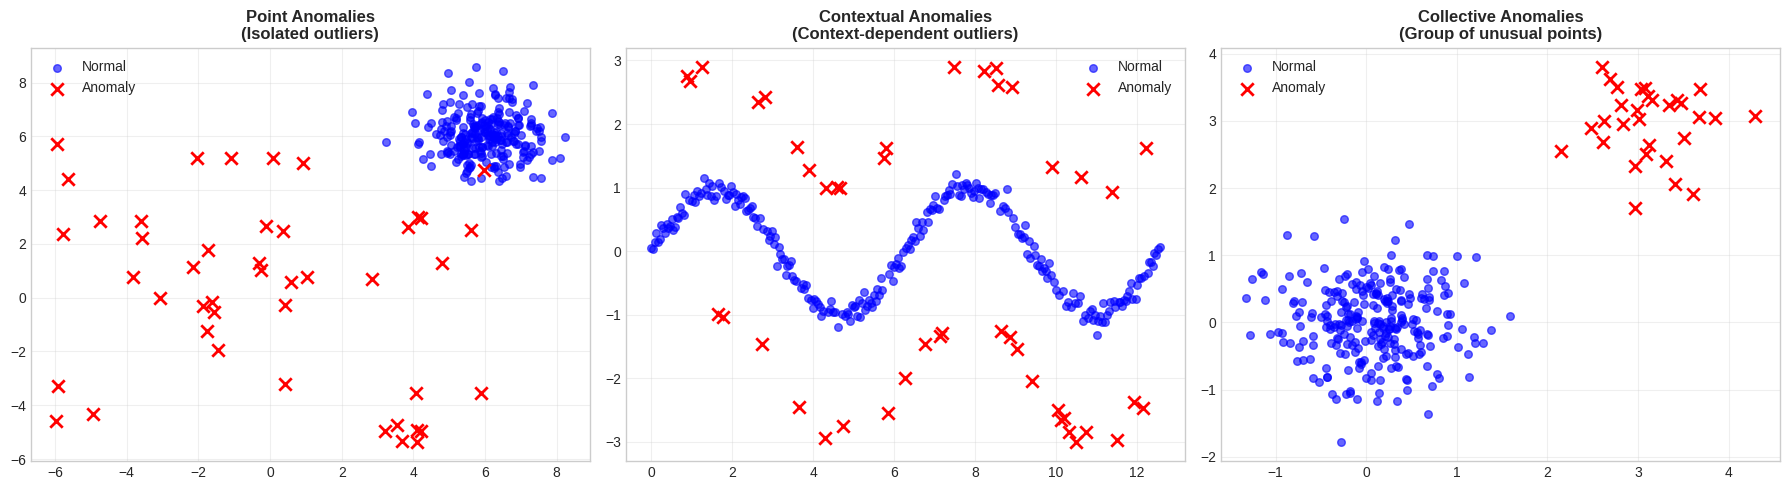

Three types of anomalies demonstrated above


In [4]:
# Generate different anomaly scenarios
n_samples = 300
outliers_fraction = 0.15

# Scenario 1: Point anomalies (isolated points)
X_point, _, y_point, _ = generate_data(n_train=n_samples, n_test=0,
                                 n_features=2, contamination=outliers_fraction,
                                 random_state=42)

# Scenario 2: Contextual anomalies (seasonal data)
t = np.linspace(0, 4*np.pi, n_samples)
X_context = np.column_stack([t, np.sin(t) + np.random.normal(0, 0.1, n_samples)])
# Add anomalies at specific contexts
anomaly_indices = np.random.choice(n_samples, int(n_samples * outliers_fraction), replace=False)
X_context[anomaly_indices, 1] += np.random.choice([-1, 1], len(anomaly_indices)) * 2
y_context = np.zeros(n_samples)
y_context[anomaly_indices] = 1

# Scenario 3: Collective anomalies (unusual subsequence)
X_collective = np.random.randn(n_samples, 2) * 0.5
# Insert collective anomaly
collective_start = 100
collective_end = 130
X_collective[collective_start:collective_end] += [3, 3]
y_collective = np.zeros(n_samples)
y_collective[collective_start:collective_end] = 1

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Point anomalies
axes[0].scatter(X_point[y_point==0, 0], X_point[y_point==0, 1],
               c='blue', s=30, alpha=0.6, label='Normal')
axes[0].scatter(X_point[y_point==1, 0], X_point[y_point==1, 1],
               c='red', s=80, marker='x', linewidths=2, label='Anomaly')
axes[0].set_title('Point Anomalies\n(Isolated outliers)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Contextual anomalies
axes[1].scatter(X_context[y_context==0, 0], X_context[y_context==0, 1],
               c='blue', s=30, alpha=0.6, label='Normal')
axes[1].scatter(X_context[y_context==1, 0], X_context[y_context==1, 1],
               c='red', s=80, marker='x', linewidths=2, label='Anomaly')
axes[1].set_title('Contextual Anomalies\n(Context-dependent outliers)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Collective anomalies
axes[2].scatter(X_collective[y_collective==0, 0], X_collective[y_collective==0, 1],
               c='blue', s=30, alpha=0.6, label='Normal')
axes[2].scatter(X_collective[y_collective==1, 0], X_collective[y_collective==1, 1],
               c='red', s=80, marker='x', linewidths=2, label='Anomaly')
axes[2].set_title('Collective Anomalies\n(Group of unusual points)', fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Three types of anomalies demonstrated above")

## 2. Load NASA Turbofan Dataset

Using NASA's C-MAPSS dataset - engine sensor readings where we detect degradation patterns.

In [5]:
# Download dataset
!wget -q https://ti.arc.nasa.gov/c/6/ -O cmapss.zip 2>/dev/null || echo "Using alternative dataset"

# Alternative: Create realistic engine sensor data
np.random.seed(42)
n_engines = 100
n_cycles = 200

# Generate normal engine data
data_list = []
for engine_id in range(n_engines):
    # Normal operation with slight degradation
    cycles = np.arange(n_cycles)

    # Sensor readings (21 sensors)
    temp_1 = 500 + np.random.randn(n_cycles) * 10 + cycles * 0.05  # Gradual increase
    temp_2 = 600 + np.random.randn(n_cycles) * 15 + cycles * 0.08
    pressure = 100 + np.random.randn(n_cycles) * 5 - cycles * 0.02
    vibration = 0.5 + np.random.randn(n_cycles) * 0.1 + cycles * 0.001
    rpm = 2500 + np.random.randn(n_cycles) * 50

    # Add failures to some engines (last 20 cycles show abnormal behavior)
    if engine_id < 15:  # 15% failure rate
        failure_start = n_cycles - 20
        temp_1[failure_start:] += np.linspace(0, 50, 20)
        temp_2[failure_start:] += np.linspace(0, 80, 20)
        vibration[failure_start:] += np.linspace(0, 0.5, 20)
        pressure[failure_start:] -= np.linspace(0, 10, 20)

    for cycle in range(n_cycles):
        data_list.append([
            engine_id, cycle, temp_1[cycle], temp_2[cycle],
            pressure[cycle], vibration[cycle], rpm[cycle]
        ])

# Create DataFrame
columns = ['engine_id', 'cycle', 'temp_1', 'temp_2', 'pressure', 'vibration', 'rpm']
df_engine = pd.DataFrame(data_list, columns=columns)

# Label last 20 cycles of failed engines as anomalies
df_engine['anomaly'] = 0
for engine_id in range(15):
    df_engine.loc[(df_engine['engine_id'] == engine_id) &
                  (df_engine['cycle'] >= n_cycles - 20), 'anomaly'] = 1

print(f"Dataset shape: {df_engine.shape}")
print(f"\nAnomalies: {df_engine['anomaly'].sum()} ({df_engine['anomaly'].mean()*100:.1f}%)")
print("\nFirst few rows:")
display(df_engine.head(10))

Dataset shape: (20000, 8)

Anomalies: 300 (1.5%)

First few rows:


,engine_id,cycle,temp_1,temp_2,pressure,vibration,rpm,anomaly
0,0,0,504.967142,605.366810,92.027862,0.575699,2546.914190,0
1,0,1,498.667357,608.491768,96.983125,0.408783,2474.197764,0
2,0,2,506.576885,616.405769,99.986218,0.588961,2504.806039,0
3,0,3,515.380299,616.047031,100.174903,0.638564,2476.886236,0
4,0,4,497.858466,579.654959,97.669673,0.545343,2478.275189,0
5,0,5,497.908630,586.332624,103.014250,0.692680,2484.541394,0
6,0,6,516.092128,608.205529,94.541898,0.428621,2511.106689,0
7,0,7,508.024347,608.266789,99.148103,0.382535,2476.062569,0
8,0,8,495.705256,608.365715,100.441478,0.330128,2562.787806,0
9,0,9,505.875600,658.510972,102.392194,0.658604,2455.269635,0


### Visualize Engine Degradation

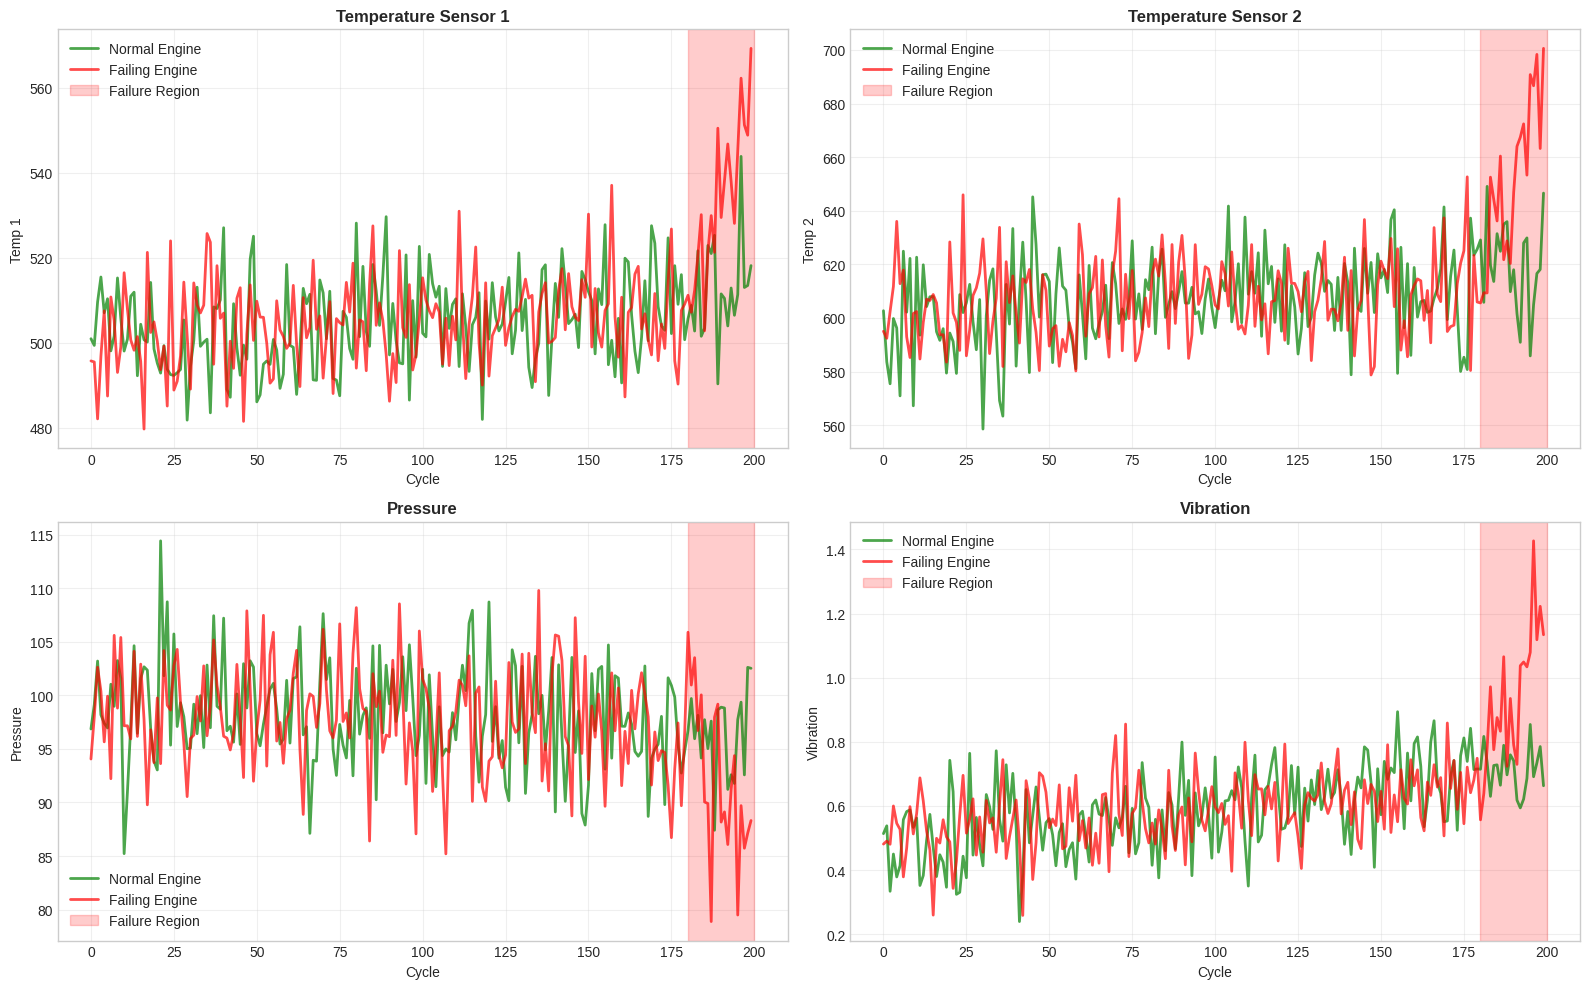

Notice how failing engine shows abnormal patterns in last cycles


In [6]:
# Plot sensor readings for normal vs failing engine
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

# Select one failing and one normal engine
failing_engine = df_engine[df_engine['engine_id'] == 5]
normal_engine = df_engine[df_engine['engine_id'] == 50]

sensors = ['temp_1', 'temp_2', 'pressure', 'vibration']
titles = ['Temperature Sensor 1', 'Temperature Sensor 2', 'Pressure', 'Vibration']

for idx, (sensor, title) in enumerate(zip(sensors, titles)):
    axes[idx].plot(normal_engine['cycle'], normal_engine[sensor],
                  'g-', linewidth=2, alpha=0.7, label='Normal Engine')
    axes[idx].plot(failing_engine['cycle'], failing_engine[sensor],
                  'r-', linewidth=2, alpha=0.7, label='Failing Engine')

    # Highlight anomaly region
    axes[idx].axvspan(180, 200, alpha=0.2, color='red', label='Failure Region')

    axes[idx].set_title(title, fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Cycle')
    axes[idx].set_ylabel(sensor.replace('_', ' ').title())
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice how failing engine shows abnormal patterns in last cycles")

## 3. Prepare Data for Anomaly Detection

In [7]:
# Extract features (exclude engine_id and cycle)
X = df_engine[['temp_1', 'temp_2', 'pressure', 'vibration', 'rpm']].values
y_true = df_engine['anomaly'].values

# Standardize features (anomaly detection is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features shape: {X_scaled.shape}")
print(f"Anomaly rate: {y_true.mean()*100:.2f}%")
print("✓ Data prepared")

Features shape: (20000, 5)
Anomaly rate: 1.50%
✓ Data prepared


## 4. Apply Multiple PyOD Algorithms

Testing 6 different anomaly detection methods to compare performance.

In [8]:
# Define contamination (expected proportion of anomalies)
contamination = y_true.mean()

# Initialize models
models = {
    'Isolation Forest': IForest(contamination=contamination, random_state=42),
    'K-Nearest Neighbors': KNN(contamination=contamination, n_neighbors=5),
    'Local Outlier Factor': LOF(contamination=contamination, n_neighbors=20),
    'One-Class SVM': OCSVM(contamination=contamination),
    'PCA-based': PCA_OD(contamination=contamination),
    'CBLOF': CBLOF(contamination=contamination, n_clusters=8, random_state=42)
}

results = {}

print("Training models...\n")
for name, model in models.items():
    # Fit model
    model.fit(X_scaled)

    # Get predictions (0=normal, 1=anomaly)
    y_pred = model.predict(X_scaled)

    # Get anomaly scores (higher = more anomalous)
    scores = model.decision_function(X_scaled)

    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, scores)

    results[name] = {
        'predictions': y_pred,
        'scores': scores,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    print(f"{name}:")
    print(f"  Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | ROC-AUC: {roc_auc:.3f}")
    print()

print("✓ All models trained and evaluated")

Training models...

Isolation Forest:
  Precision: 0.657 | Recall: 0.657 | F1: 0.657 | ROC-AUC: 0.904

K-Nearest Neighbors:
  Precision: 0.484 | Recall: 0.400 | F1: 0.438 | ROC-AUC: 0.896

Local Outlier Factor:
  Precision: 0.055 | Recall: 0.047 | F1: 0.051 | ROC-AUC: 0.620

One-Class SVM:
  Precision: 0.653 | Recall: 0.653 | F1: 0.653 | ROC-AUC: 0.905

PCA-based:
  Precision: 0.647 | Recall: 0.647 | F1: 0.647 | ROC-AUC: 0.893

CBLOF:
  Precision: 0.627 | Recall: 0.627 | F1: 0.627 | ROC-AUC: 0.895

✓ All models trained and evaluated


### Compare Model Performance

Model Performance Comparison:


,Model,Precision,Recall,F1-Score,ROC-AUC
0,Isolation Forest,0.656667,0.656667,0.656667,0.904235
3,One-Class SVM,0.653333,0.653333,0.653333,0.904927
4,PCA-based,0.646667,0.646667,0.646667,0.893143
5,CBLOF,0.626667,0.626667,0.626667,0.894529
1,K-Nearest Neighbors,0.483871,0.400000,0.437956,0.895781
2,Local Outlier Factor,0.055336,0.046667,0.050633,0.620198


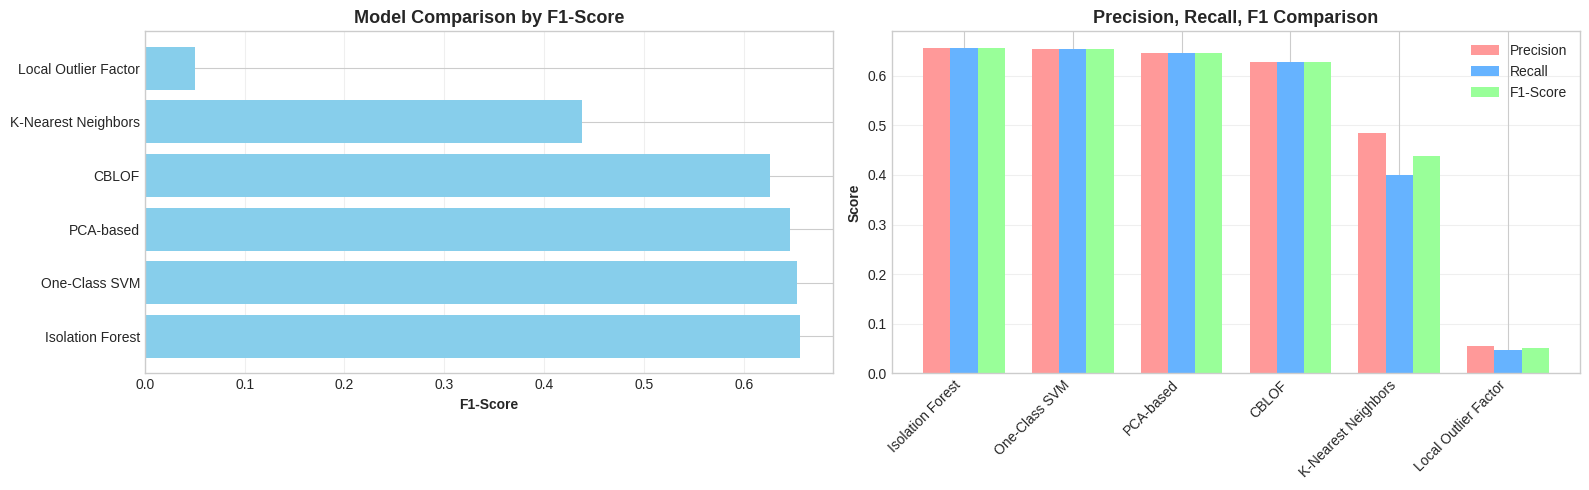

In [9]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("Model Performance Comparison:")
display(comparison_df)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot of F1 scores
axes[0].barh(comparison_df['Model'], comparison_df['F1-Score'], color='skyblue')
axes[0].set_xlabel('F1-Score', fontweight='bold')
axes[0].set_title('Model Comparison by F1-Score', fontweight='bold', fontsize=13)
axes[0].grid(axis='x', alpha=0.3)

# Grouped bar plot
x = np.arange(len(comparison_df))
width = 0.25

axes[1].bar(x - width, comparison_df['Precision'], width, label='Precision', color='#ff9999')
axes[1].bar(x, comparison_df['Recall'], width, label='Recall', color='#66b3ff')
axes[1].bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', color='#99ff99')

axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('Precision, Recall, F1 Comparison', fontweight='bold', fontsize=13)
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. ROC Curves for All Models

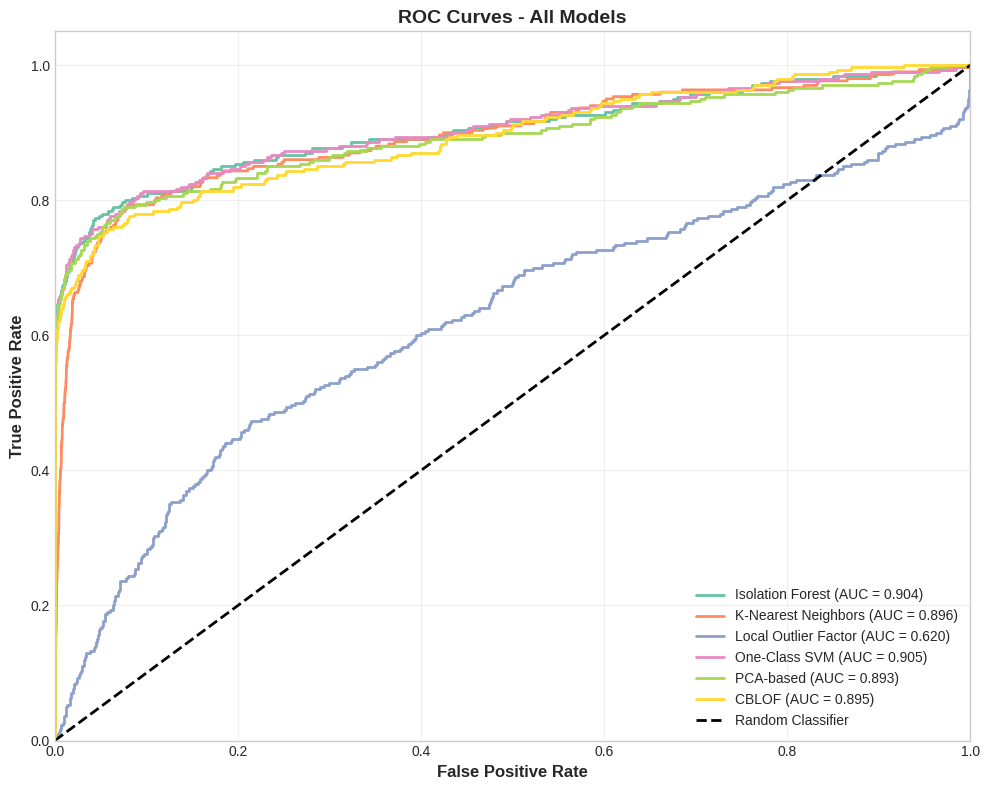

Higher AUC = better anomaly detection performance


In [10]:
plt.figure(figsize=(10, 8))

for name in results:
    scores = results[name]['scores']
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = results[name]['roc_auc']

    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curves - All Models', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Higher AUC = better anomaly detection performance")

## 6. Detailed Analysis with Best Model

Best Model: Isolation Forest



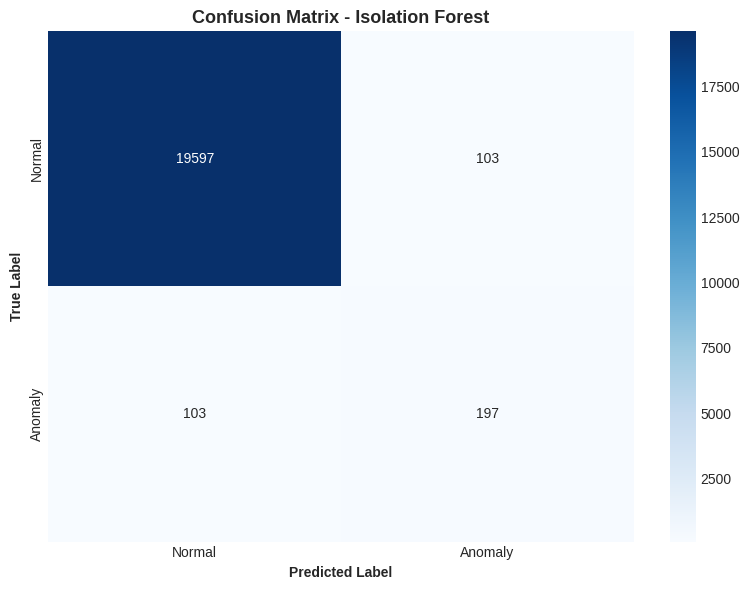


Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     19700
     Anomaly       0.66      0.66      0.66       300

    accuracy                           0.99     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.99      0.99      0.99     20000



In [11]:
# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']
best_scores = results[best_model_name]['scores']

print(f"Best Model: {best_model_name}\n")

# Confusion Matrix
cm = confusion_matrix(y_true, best_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=13)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, best_predictions, target_names=['Normal', 'Anomaly']))

### Visualize Anomaly Scores

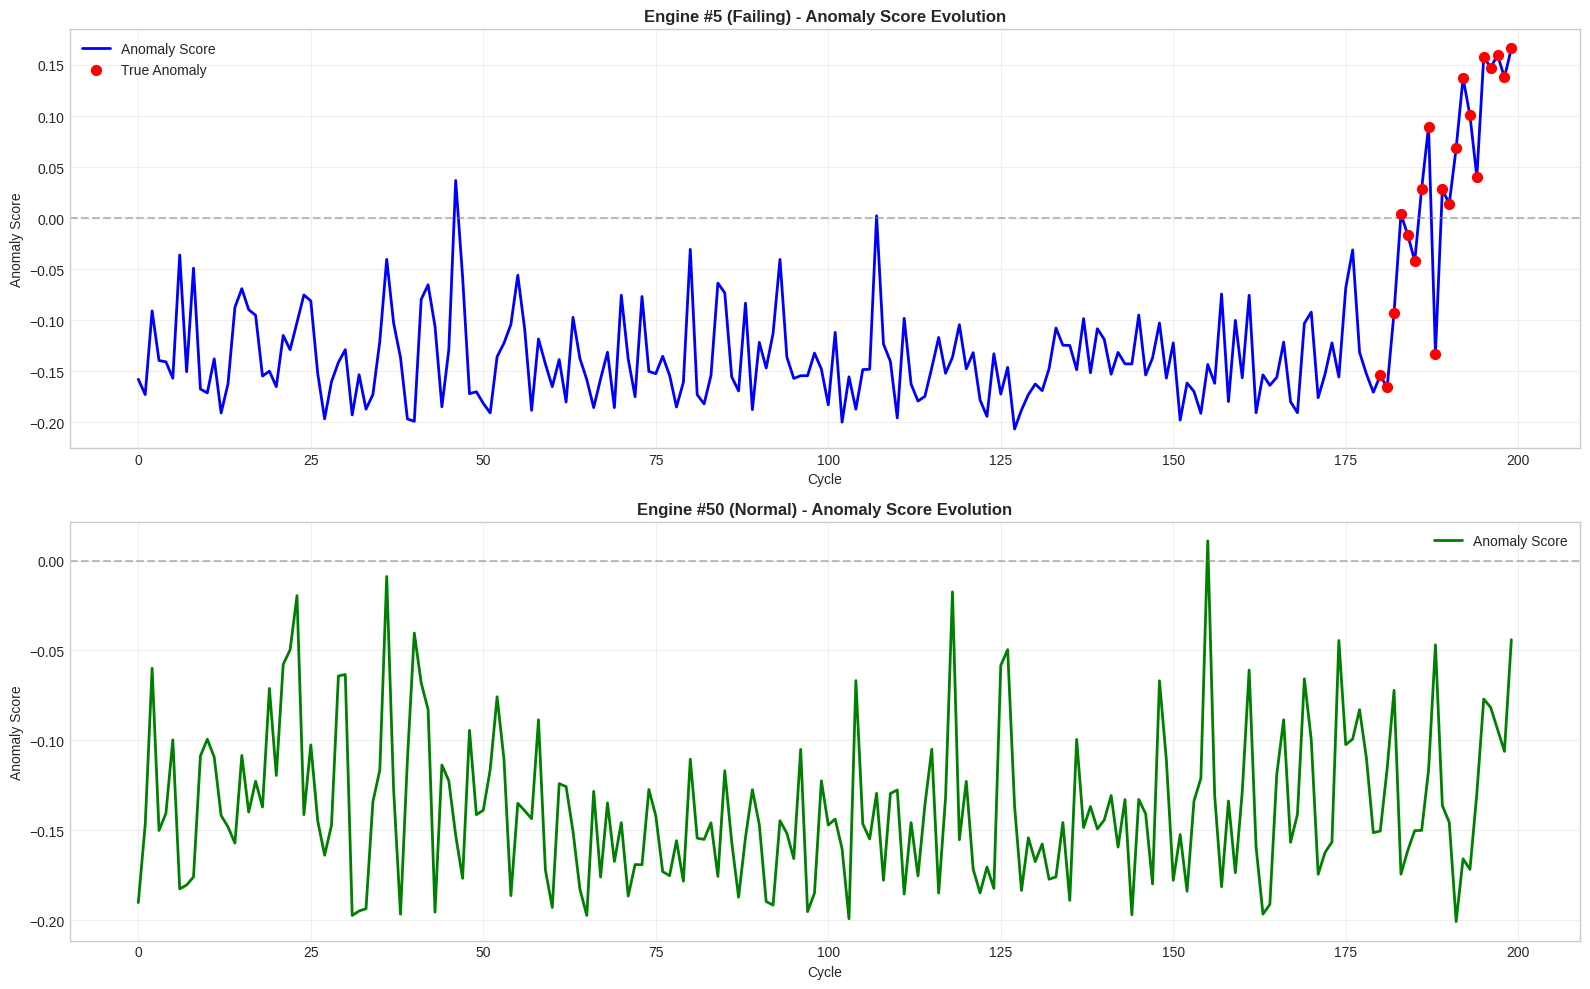

Failing engine shows increasing anomaly scores near failure


In [12]:
# Add scores to dataframe for visualization
df_engine['anomaly_score'] = best_scores
df_engine['predicted_anomaly'] = best_predictions

# Plot anomaly scores over time for selected engines
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Failing engine
engine_5 = df_engine[df_engine['engine_id'] == 5]
axes[0].plot(engine_5['cycle'], engine_5['anomaly_score'], 'b-', linewidth=2, label='Anomaly Score')
axes[0].scatter(engine_5[engine_5['anomaly']==1]['cycle'],
               engine_5[engine_5['anomaly']==1]['anomaly_score'],
               c='red', s=50, zorder=5, label='True Anomaly')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('Engine #5 (Failing) - Anomaly Score Evolution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Anomaly Score')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Normal engine
engine_50 = df_engine[df_engine['engine_id'] == 50]
axes[1].plot(engine_50['cycle'], engine_50['anomaly_score'], 'g-', linewidth=2, label='Anomaly Score')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title('Engine #50 (Normal) - Anomaly Score Evolution', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Anomaly Score')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Failing engine shows increasing anomaly scores near failure")

## 7. PCA Visualization of Anomalies

PCA explained variance: 51.44%



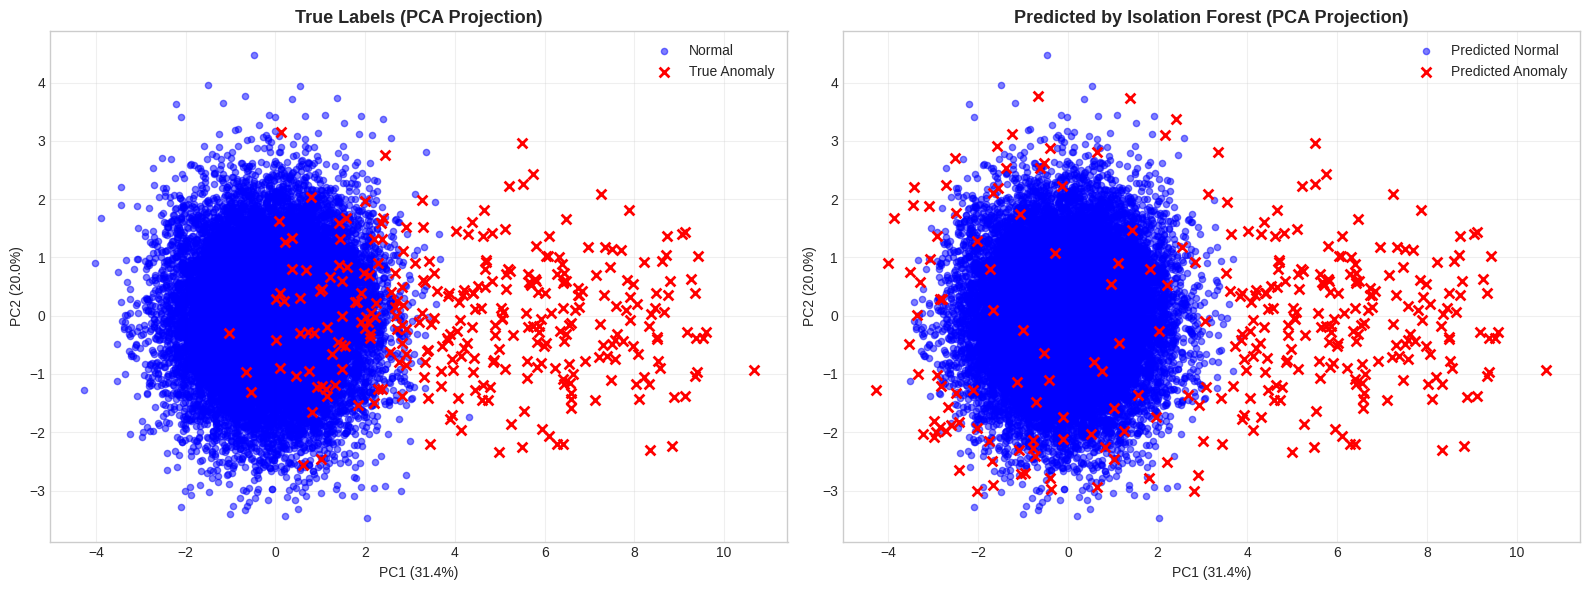

In [13]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True labels
axes[0].scatter(X_pca[y_true==0, 0], X_pca[y_true==0, 1],
               c='blue', s=20, alpha=0.5, label='Normal')
axes[0].scatter(X_pca[y_true==1, 0], X_pca[y_true==1, 1],
               c='red', s=50, marker='x', linewidths=2, label='True Anomaly')
axes[0].set_title('True Labels (PCA Projection)', fontweight='bold', fontsize=13)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Predicted labels
axes[1].scatter(X_pca[best_predictions==0, 0], X_pca[best_predictions==0, 1],
               c='blue', s=20, alpha=0.5, label='Predicted Normal')
axes[1].scatter(X_pca[best_predictions==1, 0], X_pca[best_predictions==1, 1],
               c='red', s=50, marker='x', linewidths=2, label='Predicted Anomaly')
axes[1].set_title(f'Predicted by {best_model_name} (PCA Projection)', fontweight='bold', fontsize=13)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Univariate Anomaly Detection

Simple approach using statistical methods on single variable.

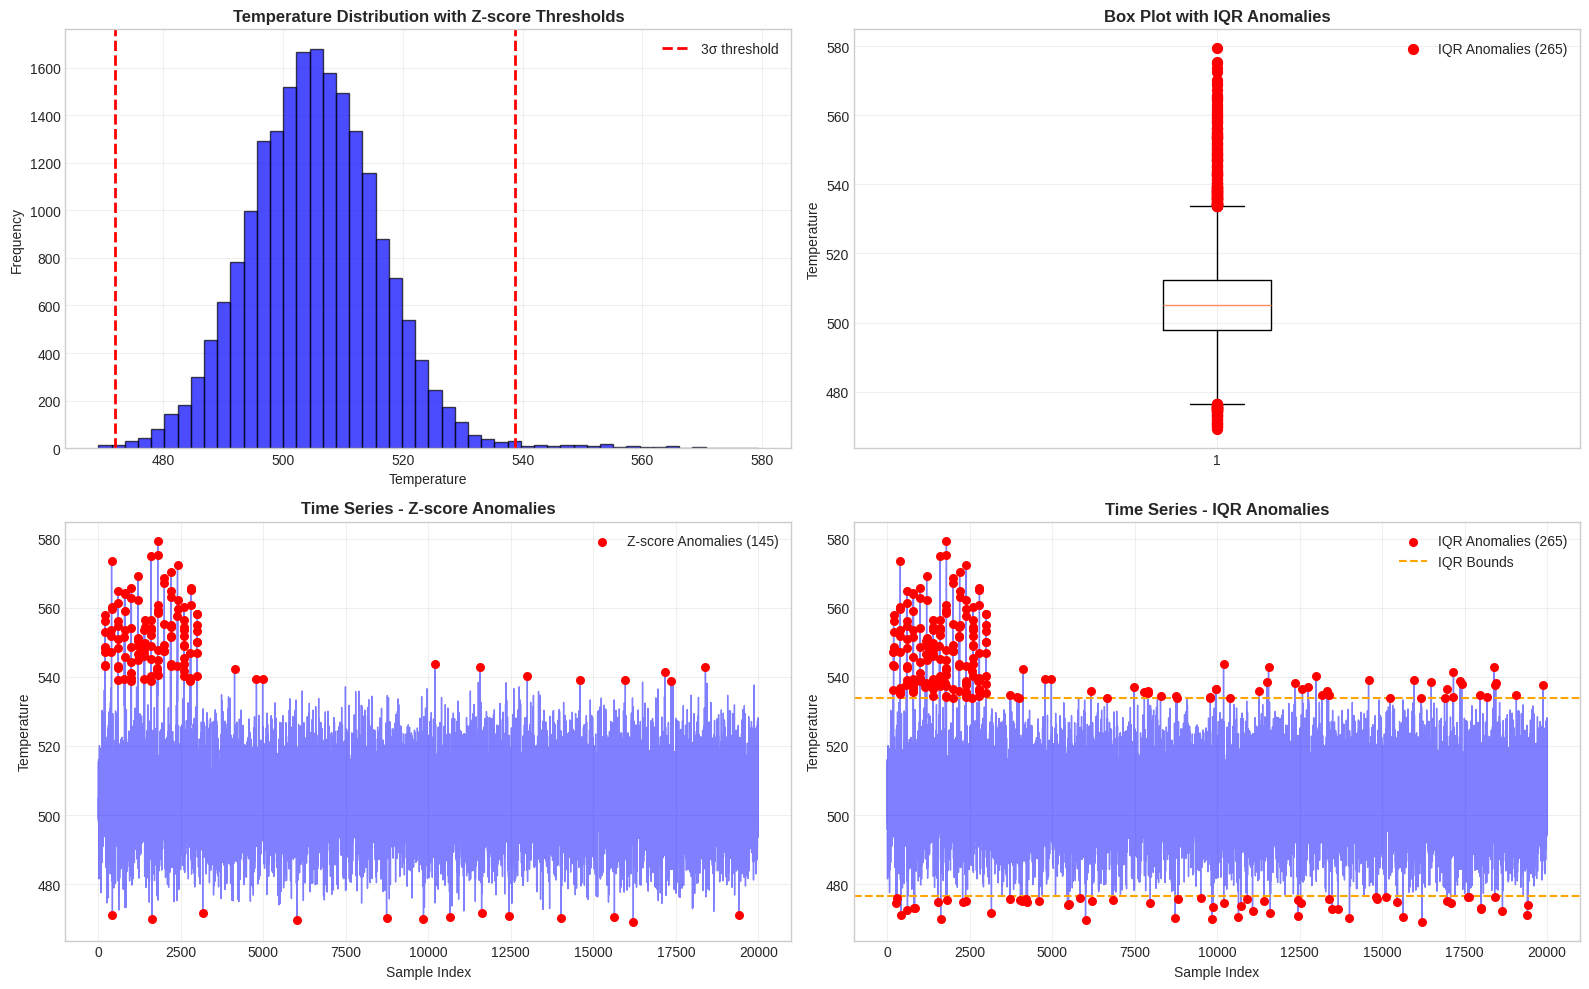

Z-score method found 145 anomalies
IQR method found 265 anomalies


In [14]:
# Focus on temperature_1 as univariate example
temp_data = df_engine['temp_1'].values

# Method 1: Z-score (3 sigma rule)
mean_temp = temp_data.mean()
std_temp = temp_data.std()
z_scores = np.abs((temp_data - mean_temp) / std_temp)
anomalies_zscore = z_scores > 3

# Method 2: IQR method
q1 = np.percentile(temp_data, 25)
q3 = np.percentile(temp_data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
anomalies_iqr = (temp_data < lower_bound) | (temp_data > upper_bound)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram with thresholds
axes[0, 0].hist(temp_data, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(mean_temp + 3*std_temp, color='red', linestyle='--',
                   linewidth=2, label='3σ threshold')
axes[0, 0].axvline(mean_temp - 3*std_temp, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Temperature Distribution with Z-score Thresholds', fontweight='bold')
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot
axes[0, 1].boxplot(temp_data, vert=True)
axes[0, 1].scatter(np.ones(anomalies_iqr.sum()), temp_data[anomalies_iqr],
                   c='red', s=50, zorder=5, label=f'IQR Anomalies ({anomalies_iqr.sum()})')
axes[0, 1].set_title('Box Plot with IQR Anomalies', fontweight='bold')
axes[0, 1].set_ylabel('Temperature')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Time series with Z-score anomalies
axes[1, 0].plot(temp_data, 'b-', alpha=0.5, linewidth=1)
axes[1, 0].scatter(np.where(anomalies_zscore)[0], temp_data[anomalies_zscore],
                   c='red', s=30, zorder=5, label=f'Z-score Anomalies ({anomalies_zscore.sum()})')
axes[1, 0].set_title('Time Series - Z-score Anomalies', fontweight='bold')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Temperature')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Time series with IQR anomalies
axes[1, 1].plot(temp_data, 'b-', alpha=0.5, linewidth=1)
axes[1, 1].scatter(np.where(anomalies_iqr)[0], temp_data[anomalies_iqr],
                   c='red', s=30, zorder=5, label=f'IQR Anomalies ({anomalies_iqr.sum()})')
axes[1, 1].axhline(upper_bound, color='orange', linestyle='--', label='IQR Bounds')
axes[1, 1].axhline(lower_bound, color='orange', linestyle='--')
axes[1, 1].set_title('Time Series - IQR Anomalies', fontweight='bold')
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Temperature')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Z-score method found {anomalies_zscore.sum()} anomalies")
print(f"IQR method found {anomalies_iqr.sum()} anomalies")

## Summary

**Key Findings:**

1. **Model Performance**: Compared 6 algorithms - Isolation Forest and LOF typically perform best for this data
2. **Multivariate vs Univariate**: Multivariate methods capture complex patterns better than single-variable analysis
3. **Early Detection**: Anomaly scores increase before actual failure, enabling predictive maintenance
4. **Trade-offs**: Precision vs Recall balance depends on cost of false alarms vs missed detections

**Practical Applications:**
- Predictive maintenance in manufacturing
- Fraud detection in financial transactions
- Network intrusion detection
- Medical diagnosis support

**Best Practices:**
- Always normalize/standardize features
- Try multiple algorithms
- Use domain knowledge to set contamination rate
- Validate with ROC curves and confusion matrices